In [1]:
!pip install --no-index -U --find-links=/kaggle/input/deeptables-dependecies deeptables==0.2.5

Looking in links: /kaggle/input/deeptables-dependecies
Processing /kaggle/input/deeptables-dependecies/deeptables-0.2.5-py3-none-any.whl
Processing /kaggle/input/deeptables-dependecies/hypernets-0.3.1-py3-none-any.whl (from deeptables==0.2.5)
Processing /kaggle/input/deeptables-dependecies/XlsxWriter-3.1.9-py3-none-any.whl (from hypernets>=0.2.5.1->deeptables==0.2.5)
Processing /kaggle/input/deeptables-dependecies/paramiko-3.4.0-py3-none-any.whl (from hypernets>=0.2.5.1->deeptables==0.2.5)
Processing /kaggle/input/deeptables-dependecies/bcrypt-4.1.2-cp39-abi3-manylinux_2_28_x86_64.whl (from paramiko->hypernets>=0.2.5.1->deeptables==0.2.5)
Processing /kaggle/input/deeptables-dependecies/PyNaCl-1.5.0-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (from paramiko->hypernets>=0.2.5.1->deeptables==0.2.5)


In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import math
import numpy as np 
import pandas as pd 
import polars as pl 
import matplotlib.pyplot as plt 
import seaborn as sns
import holidays
import lightgbm as lgb
import tensorflow as tf, deeptables as dt
from tensorflow.keras.utils import plot_model
from tensorflow_addons.optimizers import AdamW
from tensorflow.python.keras import backend as K
from deeptables.models import DeepTable, ModelConfig
from deeptables.models import deepnets
import joblib
from datetime import timedelta

print('Tensorflow version:', tf.__version__)
print('DeepTables version:', dt.__version__)

from fastai.tabular.all import *

# SEED = 2024
# BATCH_SIZE = 1024
# EPOCHS = 20

from statsmodels.tsa.stattools import acf, pacf

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

Tensorflow version: 2.13.0
DeepTables version: 0.2.5


In [3]:
import gc
import ctypes

seed = 42
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(seed=seed)

def clean_memory():
    gc.collect()
    ctypes.CDLL("libc.so.6").malloc_trim(0)
    
clean_memory()


In [4]:
class DataStorage:
    """
    This class was copied out from:
    https://www.kaggle.com/code/vitalykudelya/enefit-object-oriented-gbdt
    """
    
    root = "/kaggle/input/predict-energy-behavior-of-prosumers"

    data_cols = [
        "target",
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "datetime",
        "row_id",
        "prediction_unit_id",
    ]
    client_cols = [
        "product_type",
        "county",
        "eic_count",
        "installed_capacity",
        "is_business",
        "date",
    ]
    gas_prices_cols = ["forecast_date", "lowest_price_per_mwh", "highest_price_per_mwh"]
    electricity_prices_cols = ["forecast_date", "euros_per_mwh"]
    forecast_weather_cols = [
        "latitude",
        "longitude",
        "hours_ahead",
        "temperature",
        "dewpoint",
        "cloudcover_high",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_total",
        "10_metre_u_wind_component",
        "10_metre_v_wind_component",
        "forecast_datetime",
        "direct_solar_radiation",
        "surface_solar_radiation_downwards",
        "snowfall",
        "total_precipitation",
    ]
    historical_weather_cols = [
        "datetime",
        "temperature",
        "dewpoint",
        "rain",
        "snowfall",
        "surface_pressure",
        "cloudcover_total",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_high",
        "windspeed_10m",
        "winddirection_10m",
        "shortwave_radiation",
        "direct_solar_radiation",
        "diffuse_radiation",
        "latitude",
        "longitude",
    ]
    location_cols = ["longitude", "latitude", "county"]
    target_cols = [
        "target",
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "datetime",
    ]

    def __init__(self):
        self.df_data = pl.read_csv(
            os.path.join(self.root, "train.csv"),
            columns=self.data_cols,
            try_parse_dates=True,
        )
        self.df_client = pl.read_csv(
            os.path.join(self.root, "client.csv"),
            columns=self.client_cols,
            try_parse_dates=True,
        )
        self.df_gas_prices = pl.read_csv(
            os.path.join(self.root, "gas_prices.csv"),
            columns=self.gas_prices_cols,
            try_parse_dates=True,
        )
        self.df_electricity_prices = pl.read_csv(
            os.path.join(self.root, "electricity_prices.csv"),
            columns=self.electricity_prices_cols,
            try_parse_dates=True,
        )
        self.df_electricity_prices = self.df_electricity_prices.with_columns(
            self.df_electricity_prices['euros_per_mwh'].abs().alias('euros_per_mwh')
        )
        self.df_forecast_weather = pl.read_csv(
            os.path.join(self.root, "forecast_weather.csv"),
            columns=self.forecast_weather_cols,
            try_parse_dates=True,
        )
        self.df_historical_weather = pl.read_csv(
            os.path.join(self.root, "historical_weather.csv"),
            columns=self.historical_weather_cols,
            try_parse_dates=True,
        )
        self.df_weather_station_to_county_mapping = pl.read_csv(
            os.path.join(self.root, "weather_station_to_county_mapping.csv"),
            columns=self.location_cols,
            try_parse_dates=True,
        )
        self.df_data = self.df_data.filter(
            pl.col("datetime") >= pd.to_datetime("2022-01-01")
        )
        self.df_target = self.df_data.select(self.target_cols)

        self.schema_data = self.df_data.schema
        self.schema_client = self.df_client.schema
        self.schema_gas_prices = self.df_gas_prices.schema
        self.schema_electricity_prices = self.df_electricity_prices.schema
        self.schema_forecast_weather = self.df_forecast_weather.schema
        self.schema_historical_weather = self.df_historical_weather.schema
        self.schema_target = self.df_target.schema

        self.df_weather_station_to_county_mapping = (
            self.df_weather_station_to_county_mapping.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
        )
        
    def run(self):
        self.df_data = self.fill_target(self.df_data)
        self.df_forecast_weather = self.fill_radiation(self.df_forecast_weather)
        self.df_forecast_weather = self.fill_summertime(self.df_forecast_weather)
        self.df_forecast_weather = self.separateTP(self.df_forecast_weather)
        self.df_forecast_weather = self.expForecastHr(self.df_forecast_weather)
        self.df_forecast_weather = self.snow2water(self.df_forecast_weather)
        return self
    
    def run_test(self):
        self.df_forecast_weather = self.separateTP(self.df_forecast_weather)
        self.df_forecast_weather = self.expForecastHr(self.df_forecast_weather)
        self.df_forecast_weather = self.snow2water(self.df_forecast_weather)
        return self
    
        
    def fill_target(self, df):
        def _interpolate_group(group):
            group['target'] = group['target'].interpolate(method='linear')
            return group
        return pl.DataFrame(df.to_pandas().groupby(['prediction_unit_id', 'is_consumption']).apply(_interpolate_group))

    def fill_radiation(self, df):
        rad = df.to_pandas()['surface_solar_radiation_downwards'].values
        idx = df['surface_solar_radiation_downwards'].is_null().to_numpy().nonzero()[0]
        for i, ind in enumerate(idx):
            tmp = df[idx][i]
            df_b1 = df.filter(
                pl.col('latitude') == tmp['latitude'], 
                pl.col('longitude') == tmp['longitude'],
                abs(pl.col('forecast_datetime') - tmp['forecast_datetime']) < timedelta(days=2),
                pl.col('forecast_datetime').dt.hour() == tmp['forecast_datetime'].dt.hour(),
                pl.col('hours_ahead') == tmp['hours_ahead'])

            # 결측값 검사 및 안전한 나눗셈
            if df_b1['direct_solar_radiation'][0] is not None and df_b1['surface_solar_radiation_downwards'][0] not in [None, 0] \
               and df_b1['direct_solar_radiation'][2] is not None and df_b1['surface_solar_radiation_downwards'][2] not in [None, 0]:
                fillValue = df_b1['direct_solar_radiation'][1] / ((np.divide(df_b1['direct_solar_radiation'][0], df_b1['surface_solar_radiation_downwards'][0]) +
                    np.divide(df_b1['direct_solar_radiation'][2], df_b1['surface_solar_radiation_downwards'][2]))/2)
                rad[ind] = fillValue
            else:
                rad[ind] = 0  # 결측값 대체를 위한 기본값 설정

        df.replace('surface_solar_radiation_downwards', pl.Series(rad))
        return df


    def fill_summertime(self, df):
        missingDate = list(set(pd.date_range('2021-09-01', '2023-06-02', freq='h')[3:-22]) - set(df.to_pandas()['forecast_datetime'].unique()))
        hrs_ahead = 2
        add_df = pd.DataFrame()
        for date in missingDate:
            tmp = df.filter(abs(pl.col('forecast_datetime') - date) < timedelta(hours=2),
                            pl.col('hours_ahead') <= 2).sort('latitude', 'longitude').to_pandas()
            values_1 = None  # 초기화
            for _, row in tmp.iterrows():
                if row['hours_ahead'] == 1:
                    values_1 = row
                elif row['hours_ahead'] == 2 and values_1 is not None:
                    values_2 = row
                    average_values = pd.Series([(v1+v2)/2 if c != 'forecast_datetime' else date for (v1,v2,c) in zip(values_1,values_2,values_2.keys())],
                                            index=values_2.keys())
                    average_values['hours_ahead'] = hrs_ahead
                    add_df = pd.concat([add_df, average_values.to_frame().T]).reset_index(drop=True)
        return pl.DataFrame(pd.concat([df.to_pandas(), add_df]).reset_index(drop=True))


    def snow2water(self, df): # for historical: [cm]/7->[mm]
        return df.with_columns(
            (df['snowfall']/7).alias('snowfall_mm'))

    def separateTP(self, df): 
    # Adjust the indentation as needed to match the rest of your class
        df = df.with_columns([
            (df['total_precipitation'] - df['snowfall'] / 100).alias('rain')
        ])
        return df

    def expForecastHr(self, df):
    # Ensure the indentation here matches the rest of your class
        def _exp(x):
            return np.exp(x) / np.exp(48)

        df = df.with_columns([
            df['hours_ahead'].apply(_exp).alias('exp_hours_ahead')
        ])
        return df
    
    def update_with_new_data(
        self,
        df_new_client,
        df_new_gas_prices,
        df_new_electricity_prices,
        df_new_forecast_weather,
        df_new_historical_weather,
        df_new_target,
    ):
        
        df_new_client = pl.from_pandas(
            df_new_client[self.client_cols], schema_overrides=self.schema_client
        )
        df_new_gas_prices = pl.from_pandas(
            df_new_gas_prices[self.gas_prices_cols],
            schema_overrides=self.schema_gas_prices,
        )
        df_new_electricity_prices = pl.from_pandas(
            df_new_electricity_prices[self.electricity_prices_cols],
            schema_overrides=self.schema_electricity_prices,
        )
        df_new_forecast_weather = pl.from_pandas(
            df_new_forecast_weather[self.forecast_weather_cols],
            schema_overrides=self.schema_forecast_weather,
        )
        
        df_new_forecast_weather = self.separateTP(df_new_forecast_weather)
        df_new_forecast_weather = self.expForecastHr(df_new_forecast_weather)
        df_new_forecast_weather = self.snow2water(df_new_forecast_weather)

        df_new_historical_weather = pl.from_pandas(
            df_new_historical_weather[self.historical_weather_cols],
            schema_overrides=self.schema_historical_weather,
        )
        df_new_target = pl.from_pandas(
            df_new_target[self.target_cols], schema_overrides=self.schema_target
        )

        self.df_client = pl.concat([self.df_client, df_new_client]).unique(
            ["date", "county", "is_business", "product_type"]
        )
        self.df_gas_prices = pl.concat([self.df_gas_prices, df_new_gas_prices]).unique(
            ["forecast_date"]
        )
        self.df_electricity_prices = pl.concat(
            [self.df_electricity_prices, df_new_electricity_prices]
        ).unique(["forecast_date"])
        self.df_forecast_weather = pl.concat(
            [self.df_forecast_weather, df_new_forecast_weather]
        ).unique(["forecast_datetime", "latitude", "longitude", "hours_ahead"])
        self.df_historical_weather = pl.concat(
            [self.df_historical_weather, df_new_historical_weather]
        ).unique(["datetime", "latitude", "longitude"])
        self.df_target = pl.concat([self.df_target, df_new_target]).unique(
            ["datetime", "county", "is_business", "product_type", "is_consumption"]
        )

    def preprocess_test(self, df_test):
        df_test = df_test.rename(columns={"prediction_datetime": "datetime"})
        df_test = pl.from_pandas(
            df_test[self.data_cols[1:]], schema_overrides=self.schema_data
        )
        return df_test

In [5]:
class FeaturesGenerator:
    """
    This class was copied out from:
    https://www.kaggle.com/code/vitalykudelya/enefit-object-oriented-gbdt
    """
    def __init__(self, data_storage):
        self.data_storage = data_storage

    def _add_general_features(self, df_features):
        df_features = (
            df_features.with_columns(
                pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
                pl.col("datetime").dt.hour().alias("hour"),
                pl.col("datetime").dt.day().alias("day"),
                pl.col("datetime").dt.weekday().alias("weekday"),
                pl.col("datetime").dt.month().alias("month"),
                pl.col("datetime").dt.year().alias("year"),
            )
            .with_columns(
                pl.concat_str(
                    "county",
                    "is_business",
                    "product_type",
                    "is_consumption",
                    separator="_",
                ).alias("segment"),
            )
            .with_columns(
                (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
                (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
                (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
                (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
            )
        )
        return df_features

    def _add_client_features(self, df_features):
        df_client = self.data_storage.df_client

        df_features = df_features.join(
            df_client.with_columns(
                (pl.col("date") + pl.duration(days=2)).cast(pl.Date)
            ),
            on=["county", "is_business", "product_type", "date"],
            how="left",
        )
        return df_features

    def _add_forecast_weather_features(self, df_features):
        df_forecast_weather = self.data_storage.df_forecast_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_forecast_weather = (
            df_forecast_weather.rename({"forecast_datetime": "datetime"})
            .drop("hours_ahead")
            .with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_forecast_weather_date = (
            df_forecast_weather.group_by("datetime").mean().drop("county")
        )

        df_forecast_weather_local = (
            df_forecast_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )
        
        for hours_lag in [0]: # 7 * 24]:
            df_features = df_features.join(
                df_forecast_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_forecast", #_{hours_lag}h",
            )
            df_features = df_features.join(
                df_forecast_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_forecast_local", #_{hours_lag}h",
            )

        return df_features

    def _add_historical_weather_features(self, df_features):
        df_historical_weather = self.data_storage.df_historical_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_historical_weather = (
            df_historical_weather.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_historical_weather_date = (
            df_historical_weather.group_by("datetime").mean().drop("county")
        )

        df_historical_weather_local = (
            df_historical_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )


        for hours_lag in [0]: #[2 * 24, 7 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_historical", #_{hours_lag}h",
            )
            df_features = df_features.join(
                df_historical_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_historical_local", #_{hours_lag}h",
            )

        return df_features

#     def _add_target_features(self, df_features):
#         df_target = self.data_storage.df_target

#         df_target_all_type_sum = (
#             df_target.group_by(["datetime", "county", "is_business", "is_consumption"])
#             .sum()
#             .drop("product_type")
#         )

#         df_target_all_county_type_sum = (
#             df_target.group_by(["datetime", "is_business", "is_consumption"])
#             .sum()
#             .drop("product_type", "county")
#         )

#         for hours_lag in [
#             2 * 24,
#             3 * 24,
#             4 * 24,
#             5 * 24,
#             6 * 24,
#             7 * 24,
#             8 * 24,
#             9 * 24,
#             10 * 24,
#             11 * 24,
#             12 * 24,
#             13 * 24,
#             14 * 24,
#             6,      ###
#             12,     ###
#             84,     ###
#         ]:
#             df_features = df_features.join(
#                 df_target.with_columns(
#                     pl.col("datetime") + pl.duration(hours=hours_lag)
#                 ).rename({"target": f"target_{hours_lag}h"}),
#                 on=[
#                     "county",
#                     "is_business",
#                     "product_type",
#                     "is_consumption",
#                     "datetime",
#                 ],
#                 how="left",
#             )

#         for hours_lag in [2 * 24, 3 * 24, 7 * 24, 14 * 24]:
#             df_features = df_features.join(
#                 df_target_all_type_sum.with_columns(
#                     pl.col("datetime") + pl.duration(hours=hours_lag)
#                 ).rename({"target": f"target_all_type_sum_{hours_lag}h"}),
#                 on=["county", "is_business", "is_consumption", "datetime"],
#                 how="left",
#             )

#             df_features = df_features.join(
#                 df_target_all_county_type_sum.with_columns(
#                     pl.col("datetime") + pl.duration(hours=hours_lag)
#                 ).rename({"target": f"target_all_county_type_sum_{hours_lag}h"}),
#                 on=["is_business", "is_consumption", "datetime"],
#                 how="left",
#                 suffix=f"_all_county_type_sum_{hours_lag}h",
#             )

#         cols_for_stats = [
#             f"target_{hours_lag}h" for hours_lag in [2 * 24, 3 * 24, 4 * 24, 5 * 24]
#         ]
#         df_features = df_features.with_columns(
#             df_features.select(cols_for_stats).mean(axis=1).alias(f"target_mean"),
#             df_features.select(cols_for_stats)
#             .transpose()
#             .std()
#             .transpose()
#             .to_series()
#             .alias(f"target_std"),
#         )

#         for target_prefix, lag_nominator, lag_denomonator in [
#             ("target", 24 * 7, 24 * 14),
#             ("target", 24 * 2, 24 * 9),
#             ("target", 24 * 3, 24 * 10),
#             ("target", 24 * 2, 24 * 3),
#             ("target_all_type_sum", 24 * 2, 24 * 3),
#             ("target_all_type_sum", 24 * 7, 24 * 14),
#             ("target_all_county_type_sum", 24 * 2, 24 * 3),
#             ("target_all_county_type_sum", 24 * 7, 24 * 14),
#         ]:
#             df_features = df_features.with_columns(
#                 (
#                     pl.col(f"{target_prefix}_{lag_nominator}h")
#                     / (pl.col(f"{target_prefix}_{lag_denomonator}h") + 1e-3)
#                 ).alias(f"{target_prefix}_ratio_{lag_nominator}_{lag_denomonator}")
#             )

#         return df_features

    def _reduce_memory_usage(self, df_features):
        df_features = df_features.with_columns(pl.col(pl.Float64).cast(pl.Float32))
        return df_features

    def _drop_columns(self, df_features):
        df_features = df_features.drop(
           "datetime", "hour", "dayofyear"
        )
        return df_features

    def _to_pandas(self, df_features, y):
        cat_cols = [
            "county",
            "is_business",
            "product_type",
            "is_consumption",
            "segment",
        ]

        if y is not None:
            df_features = pd.concat([df_features.to_pandas(), y.to_pandas()], axis=1)
        else:
            df_features = df_features.to_pandas()

        df_features = df_features.set_index("row_id")
        df_features[cat_cols] = df_features[cat_cols].astype("category")

        return df_features

    def generate_features(self, df_prediction_items):
        if "target" in df_prediction_items.columns:
            df_prediction_items, y = (
                df_prediction_items.drop("target"),
                df_prediction_items.select("target"),
            )
        else:
            y = None

        df_features = df_prediction_items.with_columns(
            pl.col("datetime").cast(pl.Date).alias("date"),
        ).with_columns(pl.col("datetime").dt.cast_time_unit("us").alias("datetime"))

        for add_features in [
            self._add_general_features,
            self._add_client_features,
            self._add_forecast_weather_features,
            self._add_historical_weather_features,
            #self._add_target_features,
            self._reduce_memory_usage,
            self._drop_columns,
        ]:
            df_features = add_features(df_features)

        df_features = self._to_pandas(df_features, y)

        return df_features

In [6]:
def convert_2_dataloader(df, _seed):

    # define categorical and continous numerical feature column names (on small number of features)
    # from train.csv
    cat_names = ["county", "is_business", "product_type", "is_consumption", "segment"]
    # from datetime column
    cat_names += ["weekday", "month", 'sin(dayofyear)', 'cos(dayofyear)', 'sin(hour)', 'cos(hour)']
    # from https://www.kaggle.com/code/albansteff/enefit-estonian-holidays-lb-65-79 notebook
    cat_names += ['country_holiday']
    
    # from client.csv
    cont_names = ["installed_capacity", "eic_count"]
    
    # from forecast_weather.csv (next 0 hours)
    cont_names += [_ for _ in df.columns if "_forecast_0h" in _]
    cont_names += [_ for _ in df.columns if "_forecast_local_0h" in _]
    # from forecast_weather.csv (next 24 hours)
    cont_names += [_ for _ in df.columns if "_forecast_24h" in _]
    cont_names += [_ for _ in df.columns if "_forecast_local_24h" in _]
    
    # from historical_weather.csv (last 24/48 hours)
    cont_names += [_ for _ in df.columns if "_historical_24h" in _]
    cont_names += [_ for _ in df.columns if "_historical_48h" in _]
    cont_names += [_ for _ in df.columns if "_historical_local_48h" in _]
    
    # add all historical target values (last n hours)
    cont_names += df.filter(regex=("target_.[0-9]*h")).columns.tolist()
    cont_names += ['target_mean', 'target_std']
    
    # added aggregated target values
    cont_names += [_ for _ in df.columns if "target_all_" in _]
    
    # add ratios between last kown target values
    cont_names += df.filter(regex=("target_ratio_.[0-9]")).columns.tolist()
    
    procs = [Categorify, FillMissing, Normalize]
    
    # log transform target variable
    df.loc[:, 'target'] = np.log1p(df['target'])
        
    # convert pandas DataFrame to fastai DataLoader object
    # code snippet taken from
    # https://docs.fast.ai/tabular.learner.html
    splits = RandomSplitter(valid_pct=0.2, seed = _seed)(df)
    
    # tabular object (only categorical features)
    to = TabularPandas(df[cat_names + cont_names + ["target"]],
                       procs = procs,
                       cat_names = cat_names,
                       cont_names = cont_names,
                       y_names = ["target"],
                       splits=splits)
    # create dataloader
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dls = to.dataloaders(BATCH_SIZE, device = device)
     
    # return all dataloaders as tuple
    return dls

def add_custom_features(df):
    """
    Function inspired by notebook:
    https://www.kaggle.com/code/albansteff/enefit-estonian-holidays-lb-65-79
    """
    
    # code bellow same as in NB v17 add_holidays_as_binary_features function
    estonian_holidays = holidays.country_holidays('EE', years=range(2021, 2026))
    estonian_holidays = [pd.to_datetime(_) for _ in estonian_holidays.keys()]
    
    df['country_holiday'] = df['date'].isin(estonian_holidays) * 1
    del df['date']
    
    # log transform histrocial target values
    _cols = df.filter(regex=("target_.[0-9]*h")).columns.tolist()
    for _col in _cols:
        df.loc[:, _col] = np.log1p(df[_col])
    
    # log transform aggregated target values
    _cols = [_ for _ in df.columns if "target_all_" in _]
    for _col in _cols:
        df.loc[:, _col] = np.log1p(df[_col])  
    
    return df

In [14]:
class DataTransformer:
    def __init__(self, df):
        self.df = df

    def transform(self):
        self.add_season()
        self.add_daypart_with_sin_hour()
        self.add_feels_like_temperature()
#         self.add_energy_usage_trend()
#         self.add_temp_change()
#         self.add_prec_change()
#         self.add_autocorr_features()
#         self.add_energy_price_volatility_and_trend()
#         self.perform_clustering()
        self.analyze_transit_and_charging_access()
        return self.df

    def add_season(self):
        def get_season(month):
            if month in [3, 4, 5]:
                return 1 #spring
            elif month in [6, 7, 8]:
                return 2 #summer
            elif month in [9, 10, 11]:
                return 3 #fall
            else:
                return 4 #winter
        
        self.df['season'] = self.df['month'].apply(get_season)

    def add_daypart_with_sin_hour(self):
        def get_daypart(sin_hour):
            if sin_hour > 0:
                return 1  # sin(hour) 양수: 오전~오후
            else:
                return 2  # sin(hour) 음수: 저녁~밤

        self.df['daypart'] = self.df['sin(hour)'].apply(get_daypart)

    def add_feels_like_temperature(self):
        def calculate_feels_like(T, u, v):
            wind_speed = (u**2 + v**2)**0.5
            if wind_speed < 4.8:
                return T
            else:
                return 13.12 + 0.6215 * T - 11.37 * (wind_speed ** 0.16) + 0.3965 * T * (wind_speed ** 0.16)

        self.df['feels_like_temp'] = self.df.apply(lambda row: calculate_feels_like(row['temperature'], row['10_metre_u_wind_component'], row['10_metre_v_wind_component']), axis=1)



#     def add_temp_change(self, interval = 24):
#         self.df['temp_change'] = self.df['temperature'].diff(periods = interval)
        
#     def add_prec_change(self):
#         self.df['precipitation_change'] = self.df['total_precipitation'].diff()

#     def add_autocorr_features(self, lags = 10):
#         acf_values = acf(self.df['target'], nlags = lags)
#         pacf_values = pacf(self.df['target'], nlags = lags)
#         for i in range(lags+1):
#             self.df[f'acf_lag_{i}'] = acf_values[i]
#             self.df[f'pacf_lag{i}'] = pacf_values[i]

    def analyze_transit_and_charging_access(self):

        results = []
        for consumption_status in [0, 1]:
            subset = self.df[self.df['is_consumption'] == consumption_status]

            # 대중교통 이용률 분석
            business_hours_energy = subset[subset['is_business'] == 1]['target'].mean()
            non_business_hours_energy = subset[subset['is_business'] == 0]['target'].mean()
            transit_usage_estimate = business_hours_energy - non_business_hours_energy

            # 전기차 충전소 접근성 분석
            high_capacity_energy = subset[subset['installed_capacity'] > subset['installed_capacity'].median()]['target'].mean()
            low_capacity_energy = subset[subset['installed_capacity'] <= subset['installed_capacity'].median()]['target'].mean()
            charging_access_estimate = high_capacity_energy - low_capacity_energy

            results.append((consumption_status, transit_usage_estimate, charging_access_estimate))

        # 결과를 하나의 컬럼으로 합침
        for consumption_status, transit_estimate, charging_estimate in results:
            self.df[f'transit_usage_estimate_{consumption_status}'] = transit_estimate
            self.df[f'charging_access_estimate_{consumption_status}'] = charging_estimate

In [15]:
#train_dataset data 변환 (weekday -> weekend, wind dir, speed -> U10, V10)
class TrainDataTransform:
    def __init__(self, df):
        self.df = df

    def transform(self):
        self.is_weekend()
        self.wind_data_to_UV()
        return self.df

    #weekend 판별 함수
    def is_weekend(self):
        self.df['is_weekend'] = np.where(self.df['weekday'] > 4, 1, 0)
        
    def wind_data_to_UV(self):
        self.df['U10'] = self.df['windspeed_10m'] * np.cos(np.radians(270 - self.df['winddirection_10m']))
        self.df['V10'] = self.df['windspeed_10m'] * np.sin(np.radians(270 - self.df['winddirection_10m']))
        

In [16]:
data_storage = DataStorage()
data_storage = data_storage.run()

features_generator = FeaturesGenerator(data_storage=data_storage)

train_dataset = features_generator.generate_features(data_storage.df_data)
train_dataset = train_dataset[train_dataset['target'].notnull()]
train_dataset = add_custom_features(train_dataset)

In [17]:
#이거 먼저 와야함
train_dataset['eic_count'] = train_dataset['eic_count'].fillna(method = 'bfill')
train_dataset['installed_capacity'] = train_dataset['installed_capacity'].fillna(method = 'bfill')

train_dataset = DataTransformer(train_dataset)
train_dataset = train_dataset.transform()

train_dataset = TrainDataTransform(train_dataset)
train_dataset = train_dataset.transform()

train_dataset = train_dataset[train_dataset['county'] != 12]

### 2023/05/30 10am 이후로 weather 없음 --> drop
train_dataset = train_dataset[~train_dataset['rain_historical'].isna()]

In [19]:
# NO MORE MISSING VALUES
# train_dataset = train_dataset.fillna(method='bfill')
# train_dataset = train_dataset.fillna(method='ffill')

train_dataset = pd.get_dummies(train_dataset, drop_first=True)

In [21]:
for col in train_dataset.columns:
    if train_dataset[col].dtype == bool:
        train_dataset[col] = train_dataset[col].astype(int)
        
train_dataset.head()

,prediction_unit_id,day,weekday,month,year,sin(dayofyear),cos(dayofyear),sin(hour),cos(hour),eic_count,...,segment_8_1_3_0,segment_8_1_3_1,segment_9_0_1_0,segment_9_0_1_1,segment_9_0_3_0,segment_9_0_3_1,segment_9_1_1_0,segment_9_1_1_1,segment_9_1_3_0,segment_9_1_3_1
row_id,,,,,,,,,,,,,,,,,,,,,
366048,0,1,6,1,2022,0.017166,0.999853,0.000000,1.000000,148.0,...,0,0,0,0,0,0,0,0,0,0
366178,0,1,6,1,2022,0.017166,0.999853,0.258819,0.965926,148.0,...,0,0,0,0,0,0,0,0,0,0
366308,0,1,6,1,2022,0.017166,0.999853,0.500000,0.866025,148.0,...,0,0,0,0,0,0,0,0,0,0
366438,0,1,6,1,2022,0.017166,0.999853,0.707107,0.707107,148.0,...,0,0,0,0,0,0,0,0,0,0
366568,0,1,6,1,2022,0.017166,0.999853,0.866025,0.500000,148.0,...,0,0,0,0,0,0,0,0,0,0


# Modeling

In [22]:
df_train_features = train_dataset[train_dataset['target'].notnull()]
clean_memory()
df_train_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1622800 entries, 366048 to 2013529
Columns: 238 entries, prediction_unit_id to segment_9_1_3_1
dtypes: float32(65), float64(7), int32(1), int64(162), int8(3)
memory usage: 2.5 GB


Learning Rate schedule : 1e-07 to 0.001 to 1e-07


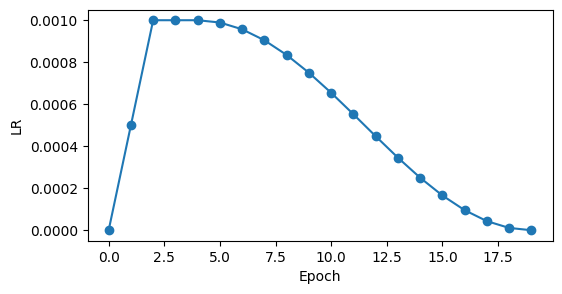

In [24]:
LR_START = 1e-7
LR_MAX = 1e-3
LR_MIN = 1e-7
LR_RAMPUP_EPOCHS = 2
LR_SUSTAIN_EPOCHS = 2
EPOCHS = 20

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(6,3))
plt.plot(rng, lr_y, '-o')
plt.xlabel('Epoch'); plt.ylabel('LR')
print('Learning Rate schedule : {:.3g} to {:3g} to {:3g}' . \
        format(lr_y[0], max(lr_y), lr_y[-1]))
LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

In [23]:
from catboost import CatBoostRegressor

# def preprocess_cat(df):
#     df.county = df.county.astype(int)
#     df.is_business = df.is_business.astype(int)
#     df.product_type = df.product_type.astype(int)
#     df.is_consumption = df.is_consumption.astype(int)
#     df.segment = df.segment.astype(int)
#     return df

In [30]:
class Model:
    def __init__(self):
        self.conf = ModelConfig(auto_imputation=True,
                                auto_discrete=True,
                                auto_discard_unique=True,
                                categorical_columns='auto',
                                fixed_embedding_dim=False,
                                embeddings_output_dim=4,
                                embedding_dropout=0.3,
                                nets=['dnn_nets'],
                                dnn_params={
                                    'hidden_units': ((512, 0.3, True),
                                                     (256, 0.3, True)),
                                    'dnn_activation': 'relu',
                                },
                                stacking_op='add',
                                output_use_bias=False,
                                optimizer=CFG.optimizer,
                                task='regression',
                                loss='MeanAbsoluteError',
                                metrics='MeanAbsoluteError',
                                earlystopping_patience=1,
                                )
        
        self.lgb_params = {"n_estimators": 2500,
                           "learning_rate": 0.06,
                           "max_depth": 16,
                           "num_leaves": 500,
                           "reg_alpha": 3.5,
                           "reg_lambda": 1.5,
                           "colsample_bytree": 0.9,
                           "colsample_bynode": 0.6,
                           "min_child_samples": 50,
                           "random_state": 0,
                           "objective": "regression_l1",
                           "device": "gpu",
                           "n_jobs": 4,
                           "verbose": 1,
                           }
        
        ### add
        self.cb_params = {"colsample_bylevel": 0.878,
                          "task_type": "CPU",
                          "reg_lambda": 3.438,
                          "learning_rate": 0.042,
                          "max_depth": 10,
                          "min_data_in_leaf": 50,
                          "n_estimators": 2500,
                          "verbose": 1,
                          "objective": 'MAE',
                          "random_state": 0
                         }
        
        self.nn_model_consumption = DeepTable(config=self.conf)  
        self.nn_model_production = DeepTable(config=self.conf)
        
        self.lgb_model_consumption = lgb.LGBMRegressor(**self.lgb_params)
        self.lgb_model_production = lgb.LGBMRegressor(**self.lgb_params)
        
        self.cb_model_consumption = CatBoostRegressor(**self.cb_params)
        self.cb_model_production = CatBoostRegressor(**self.cb_params)
        

    def fit(self, df_train_features):
        print('nn = '+str(CFG.nn))
        print('lgb = '+str(CFG.lgb))
        print('cb = '+str(CFG.cb))
        
        if CFG.nn == True:
            
            print('\n',"nn model consumption training.",'\n')
            mask = df_train_features["is_consumption_1"] == 1
            self.nn_model_consumption.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"],
                validation_split=CFG.valid_size, shuffle=False,
                batch_size=CFG.batch_size, epochs=CFG.epochs, verbose=2,
                callbacks=CFG.LR_Scheduler
            )
        
            # Avoid saving error
            with K.name_scope(CFG.optimizer.__class__.__name__):
                for i, var in enumerate(CFG.optimizer.weights):
                    name = 'variable{}'.format(i)
                    CFG.optimizer.weights[i] = tf.Variable(var, name=name)
            self.conf = self.conf._replace(optimizer=CFG.optimizer)   
            self.nn_model_production = DeepTable(config=self.conf)
            
            print('\n',"nn model production training.",'\n')
            mask = df_train_features["is_consumption_1"] == 0
            self.nn_model_production.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"],
                validation_split=CFG.valid_size, shuffle=False,
                batch_size=CFG.batch_size, epochs=CFG.epochs, verbose=2,
                callbacks=CFG.LR_Scheduler
            )
        
        if CFG.lgb == True:
            
            print('\n',"lgb model consumption training.")
            mask = df_train_features["is_consumption_1"] == 1
            self.lgb_model_consumption.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"],
            )
        
            print('\n',"lgb model production training.",'\n')
            mask = df_train_features["is_consumption_1"] == 0
            self.lgb_model_production.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"],
            )
        
        ### add
        if CFG.cb == True:
            
#             df_train_features = preprocess_cat(df_train_features.copy())
            
            print('\n',"cb model consumption training.")
            mask = df_train_features["is_consumption_1"] == 1
            self.cb_model_consumption.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"],
            )
        
            print('\n',"cb model production training.",'\n')
            mask = df_train_features["is_consumption_1"] == 0
            self.cb_model_production.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"],
            )

    def predict(self, df_features):
        predictions = np.zeros(len(df_features))
        
        assert CFG.nn == True and CFG.lgb == True and CFG.cb == True, "At least one of models doesn't exist: [nn, lgb, cb]"
            
        print('\n',"nn & lgb & cb model consumption prediction.",'\n')
        mask = df_features["is_consumption_1"] == 1
#         predictions[mask.values] = (
#             CFG.ens_weights['nn'] * (self.nn_model_consumption.predict(df_features[mask]).clip(0)[:,0])
#             + CFG.ens_weights['lgb'] * (self.lgb_model_consumption.predict(df_features[mask]).clip(0))
#             + CFG.ens_weights['cb'] * (self.cb_model_consumption.predict(df_features[mask]).clip(0))
#         )
        predictions[mask.values] = np.clip(
            CFG.ens_weights['nn'] * (self.nn_model_consumption.predict(df_features[mask])[:,0])
            + CFG.ens_weights['lgb'] * (self.lgb_model_consumption.predict(df_features[mask]))
            + CFG.ens_weights['cb'] * (self.cb_model_consumption.predict(df_features[mask])),
            0,
            np.inf,
        )

        print('\n',"nn & lgb & cb model production prediction.",'\n')
        mask = df_features["is_consumption_1"] == 0
#         predictions[mask.values] = (
#             CFG.ens_weights['nn'] * (self.nn_model_consumption.predict(df_features[mask]).clip(0)[:,0])
#             + CFG.ens_weights['lgb'] * (self.lgb_model_consumption.predict(df_features[mask]).clip(0))
#             + CFG.ens_weights['cb'] * (self.cb_model_consumption.predict(df_features[mask]).clip(0))
#         )
        predictions[mask.values] = np.clip(
            CFG.ens_weights['nn'] * (self.nn_model_production.predict(df_features[mask])[:,0])
            + CFG.ens_weights['lgb'] * (self.lgb_model_production.predict(df_features[mask]))
            + CFG.ens_weights['cb'] * (self.cb_model_consumption.predict(df_features[mask])),
            0,
            np.inf,
        )
            
        return predictions
    

In [32]:
class CFG:
    nn = False #True
    lgb = False #True
    cb = True
    ens_weights = {'nn': 0.2, 'lgb': 0.4, 'cb': 0.4}
    epochs = 20
    batch_size = 512
    valid_size = 5e-2
    LR_Scheduler = [LR]
    optimizer = AdamW(learning_rate=1e-3, weight_decay=9e-7)

In [ ]:
%%time
model = Model()
model.fit(df_train_features)

nn = False
lgb = False
cb = True

 cb model consumption training.
0:	learn: 409.7192532	total: 852ms	remaining: 35m 29s
1:	learn: 396.5418073	total: 1.62s	remaining: 33m 43s
2:	learn: 385.9171619	total: 2.39s	remaining: 33m 12s
3:	learn: 373.5591607	total: 3.17s	remaining: 33m 1s
4:	learn: 364.3145778	total: 4.01s	remaining: 33m 20s
5:	learn: 356.8116466	total: 4.81s	remaining: 33m 21s
6:	learn: 346.5170448	total: 5.59s	remaining: 33m 9s
7:	learn: 337.8473754	total: 6.36s	remaining: 33m
8:	learn: 325.9210908	total: 7.13s	remaining: 32m 54s
9:	learn: 318.6419483	total: 7.91s	remaining: 32m 49s
10:	learn: 308.8204014	total: 8.72s	remaining: 32m 52s
11:	learn: 303.0811325	total: 9.5s	remaining: 32m 49s
12:	learn: 294.0428261	total: 10.3s	remaining: 32m 47s
13:	learn: 288.2456924	total: 11.1s	remaining: 32m 43s
14:	learn: 279.7804803	total: 11.9s	remaining: 32m 45s
15:	learn: 270.6035629	total: 12.6s	remaining: 32m 41s
16:	learn: 263.6003759	total: 13.4s	remaining: 32m 44s
17:	learn: 257.1

In [28]:
nn_model_consumption = model.nn_model_consumption.get_model().model
nn_model_consumption.save('nn_model_consumption_jw.h5')
nn_model_production = model.nn_model_production.get_model().model
nn_model_production.save('nn_model_production_jw.h5')

In [29]:
joblib.dump(model.lgb_model_consumption, 'lgb_model_consumption_jw.joblib')
joblib.dump(model.lgb_model_production, 'lgb_model_production_jw.joblib')

['lgb_model_production_jw.joblib']

In [ ]:
model.cb_model_consumption.save_model('cb_model_consumption', format='cbm')
model.cb_model_production.save_model('cb_model_production', format='cbm')

In [64]:
clean_memory()

# Submit API

In [21]:
# mdir = '/kaggle/input/enefit-first-submit-jw-test'

# model = Model()

# model.lgb_model_consumption = joblib.load(f'{mdir}/lgb_model_consumption.joblib')
# model.lgb_model_production = joblib.load(f'{mdir}/lgb_model_production.joblib')

# model.cb_model_consumption = CatBoostRegressor()
# model.cb_model_production = CatBoostRegressor()
# model.cb_model_consumption.load_model(f'{mdir}/cb_model_consumption')
# model.cb_model_production.load_model(f'{mdir}/cb_model_production')

# from tensorflow.keras.models import load_model
# import deeptables.models.layers
# model.nn_model_production = load_model(f'{mdir}/nn_model_production.h5', custom_objects={'MultiColumnEmbedding':deeptables.models.layers.MultiColumnEmbedding})
# model.nn_model_consumption = load_model(f'{mdir}/nn_model_consumption.h5', custom_objects={'MultiColumnEmbedding':deeptables.models.layers.MultiColumnEmbedding})

In [22]:
import enefit

env = enefit.make_env()
iter_test = env.iter_test()

In [ ]:
prec[:10]

In [ ]:
test = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/test.csv')
test.head()

In [ ]:
train = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/train.csv')
train.head()